In [1]:
import csv
import os
import pandas as pd
import collections
import ast
import time
import collections
import json
import sqlite3
import xxhash
import numpy as np
import pickle 
import random
import glob
from io import StringIO
from pathlib import Path
from openai import OpenAI, AsyncOpenAI
import openai
print(openai.__version__)
os.environ["OPENAI_API_KEY"] = ""

openai.api_key = os.getenv("OPENAI_API_KEY")

client = OpenAI(
    # defaults to os.environ.get("OPENAI_API_KEY")
    api_key=os.getenv("OPENAI_API_KEY"),
)

1.90.0


In [2]:
from prompts.all_prompts import *
from order_by.sorting import *
from order_by.utils import *

In [3]:
import matplotlib.pyplot as plt

In [15]:
def sortedness(gold_list, sorted_data):
    inversions = num_inversions(gold_list[:], sorted_data[:])
    off = num_out_of_place(gold_list[:], sorted_data[:])
    return inversions, off

def store_metadata(d, sorted_data, inversions, outofplaces, api_calls, tokens, memory_size = 0):
    if memory_size == 0:
        d['sorted_data'] = sorted_data
        d['inversions'] = inversions
        d['out_of_places'] = outofplaces
        d['api_calls'] = api_calls
        d['tokens'] = tokens
    else:
        d[memory_size] = {}
        d[memory_size]['sorted_data'] = sorted_data
        d[memory_size]['inversions'] = inversions
        d[memory_size]['out_of_places'] = outofplaces
        d[memory_size]['api_calls'] = api_calls
        d[memory_size]['tokens'] = tokens
        
        
    
async def experiment(dataname, sort_by_columns, column_to_compare, log_filename, pointwise_prompt_template,\
               external_pointwise_prompt_template, external_comparison_prompt_template,\
               pairwise_comparison_prompt_template, out_t = float):
    random.seed(0)
    
    fname = f"{dataname}.csv"
    file_path = f"./data/{fname}"
    data = pd.read_csv(file_path)

    sorted_df = data.sort_values(by=sort_by_columns, ascending=[True, True])

    print(sorted_df.head())
    print(len(sorted_df))
    
    gold_list = data[column_to_compare].tolist()
    shuffled_list = random.sample(gold_list, len(gold_list)) # shuffle the sorted list

    results = {}
    for modelname in ["gpt-4o", "gpt-4o-mini"]:
        results[modelname] = {'pointwise_sort':{}, 'quick_sort':{}, 'heap_sort':{},\
                              'external_pointwise_sort':{}, 'external_bubble_sort':{},\
                              'external_merge_sort':{}, 'hybrid_sort':{}, 'quick_sort_5':{}}
        memory_sizes = [16]
        if modelname == 'gpt-4o-mini':
            memory_sizes = [4]
        print(modelname)
        
        sorted_data, num_api_calls, tokens, confidences = await pointwise_sort(shuffled_list, client, pointwise_prompt_template, modelname, out_t)
        inversions, off = sortedness(gold_list, sorted_data)
        print("pointwise_sort")
        print(f"inversions: {inversions}, api calls: {num_api_calls}, tokens: {tokens}, and out of place: {off}\n {confidences}")
        store_metadata(results[modelname]['pointwise_sort'], sorted_data, inversions, off, num_api_calls, tokens)

        sorted_data, num_api_calls, tokens = await quick_sort(shuffled_list, client, pairwise_comparison_prompt_template, modelname)
        inversions, off = sortedness(gold_list, sorted_data)
        print("quick_sort")
        print(f"inversions: {inversions}, api calls: {num_api_calls}, tokens: {tokens}, and out of place: {off}\n")
        store_metadata(results[modelname]['quick_sort'], sorted_data, inversions, off, num_api_calls, tokens)

        votes = 5
        sorted_data, num_api_calls, tokens = await quick_sort(shuffled_list, client, pairwise_comparison_prompt_template, modelname, votes)
        inversions, off = sortedness(gold_list, sorted_data)
        print(f"quick_sort with vote={votes}")
        print(f"inversions: {inversions}, api calls: {num_api_calls}, tokens: {tokens}, and out of place: {off}\n")
        store_metadata(results[modelname]['quick_sort_5'], sorted_data, inversions, off, num_api_calls, tokens)


        
#         sorted_data, num_api_calls, tokens = await heap_sort(shuffled_list, client, pairwise_comparison_prompt_template, modelname)
#         inversions, off = sortedness(gold_list, sorted_data)
#         print("heap_sort")
#         print(f"inversions: {inversions}, api calls: {num_api_calls}, tokens: {tokens}, and out of place: {off}\n")
#         store_metadata(results[modelname]['heap_sort'], sorted_data, inversions, off, num_api_calls, tokens)
    
        sorted_data, num_api_calls, tokens, confidences = await external_pointwise_sort(shuffled_list, external_values, client, external_pointwise_prompt_template, modelname, out_t)
        inversions, off = sortedness(gold_list, sorted_data)
        print(f"inversions: {inversions}, api calls: {num_api_calls}, tokens: {tokens}, and out of place: {off}\n {confidences}")
        store_metadata(results[modelname]['external_pointwise_sort'], sorted_data, inversions, off, num_api_calls, tokens)
            
        votes = 5
        sorted_data, num_api_calls, tokens = await hybrid_sort(shuffled_list, external_values, votes, client, external_pointwise_prompt_template, pairwise_comparison_prompt_template, modelname, out_t)
        inversions, off = sortedness(gold_list, sorted_data)
        print(f"hybrid_sort")
        print(f"inversions: {inversions}, api calls: {num_api_calls}, tokens: {tokens}, and out of place: {off}\n")
        store_metadata(results[modelname]['hybrid_sort'], sorted_data, inversions, off, num_api_calls, tokens)
            
    
        for m in memory_sizes:
            sorted_data, num_api_calls, tokens = await external_bubble_sort(shuffled_list, external_comparisons, m, client, external_comparison_prompt_template, modelname)
            inversions, off = sortedness(gold_list, sorted_data)
            print(f"external_bubble_sort {m}")
            print(f"inversions: {inversions}, api calls: {num_api_calls}, tokens: {tokens}, and out of place: {off}\n")
            store_metadata(results[modelname]['external_bubble_sort'], sorted_data, inversions, off, num_api_calls, tokens, m)


            sorted_data, num_api_calls, tokens = await external_merge_sort(shuffled_list, external_comparisons, m, client, external_comparison_prompt_template, modelname)
            inversions = num_inversions(gold_list, sorted_data)
            off = num_out_of_place(gold_list, sorted_data)
            print(f"external_merge_sort {m}")
            print(f"inversions: {inversions}, api calls: {num_api_calls}, tokens: {tokens}, and out of place: {off}\n")
            store_metadata(results[modelname]['external_merge_sort'], sorted_data, inversions, off, num_api_calls, tokens, m)


    print(results)
    with open(log_filename, "w") as log_file:
        json.dump(results, log_file, indent=4) 


In [16]:
dataname = "nba_heights_200"
column_to_sort = "full_name"
log_filename = "./logs//nba_heights.json"
await experiment(
         dataname,
        ["h_meters", "full_name"],
        "full_name",
        log_filename,
        nba_pointwise_prompt_template,
        nba_external_pointwise_prompt_template, 
        nba_external_comparison_prompt_template,
        nba_pairwise_comparison_prompt_template,
        float
    )

           full_name  h_meters
6       Paul Millsap      2.01
47        Jeff Green      2.03
94        Kevin Love      2.03
0   Luc Mbah a Moute      2.03
1        Luke Walton      2.03
200
gpt-4o
pointwise_sort
inversions: 747, api calls: 0, tokens: 73550, and out of place: 184
 [9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 10, 9, 9, 9, 9, 9, 9, 10]
quick_sort
inversions: 1645, api calls: 0, tokens: 559220, and out of place: 189

quick_sort with vote=5
inversions:

In [18]:
fname = 'nba_heights'
log_filename = f"./logs/{fname}.json"
with open(log_filename, "r") as log_file:
    loaded_data = json.load(log_file)
    
        
for modelname in loaded_data.keys():
    print()
    print(modelname)
    for external_function in ['external_bubble_sort', 'external_merge_sort']:
        print()
        for m in loaded_data[modelname][external_function].keys():
            print(external_function, f'memory size {m}')
            tokens = loaded_data[modelname][external_function][m]['tokens']
            for field in ['inversions']: #'sorted_data'
                print(field, loaded_data[modelname][external_function][m][field], tokens )
    
    for function_name in ['pointwise_sort', 'quick_sort', 'quick_sort_5','external_pointwise_sort', 'hybrid_sort']:
        print()
        print(function_name)
        tokens = loaded_data[modelname][external_function][m]['tokens']
        for field in ['inversions']: #'sorted_data'
            print(field, loaded_data[modelname][function_name][field], tokens )


gpt-4o

external_bubble_sort memory size 16
inversions 2181 181349

external_merge_sort memory size 16
inversions 5045 46285

pointwise_sort
inversions 747 46285

quick_sort
inversions 1645 46285

quick_sort_5
inversions 1642 46285

external_pointwise_sort
inversions 536 46285

hybrid_sort
inversions 586 46285

gpt-4o-mini

external_bubble_sort memory size 4
inversions 2797 1906049

external_merge_sort memory size 4
inversions 6421 187836

pointwise_sort
inversions 2826 187836

quick_sort
inversions 3990 187836

quick_sort_5
inversions 3990 187836

external_pointwise_sort
inversions 3824 187836

hybrid_sort
inversions 3728 187836


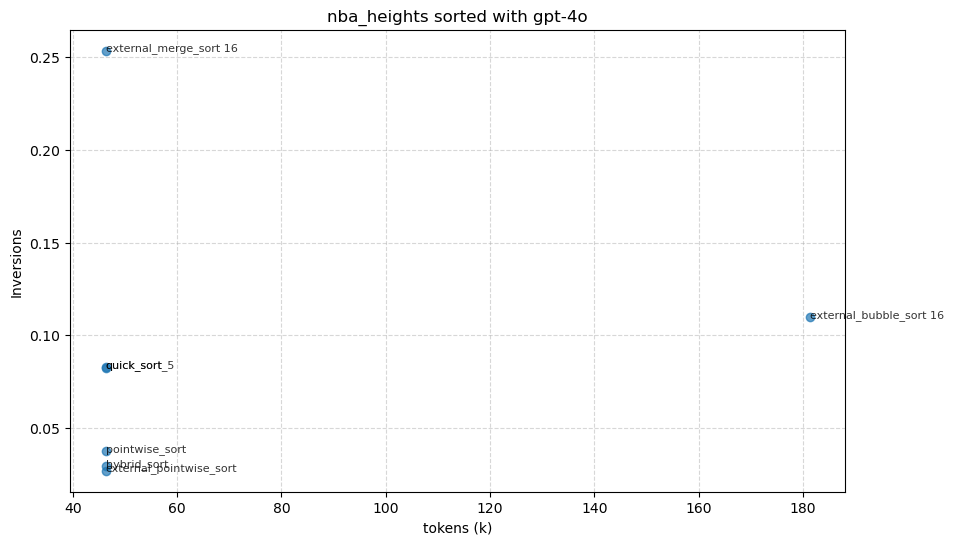

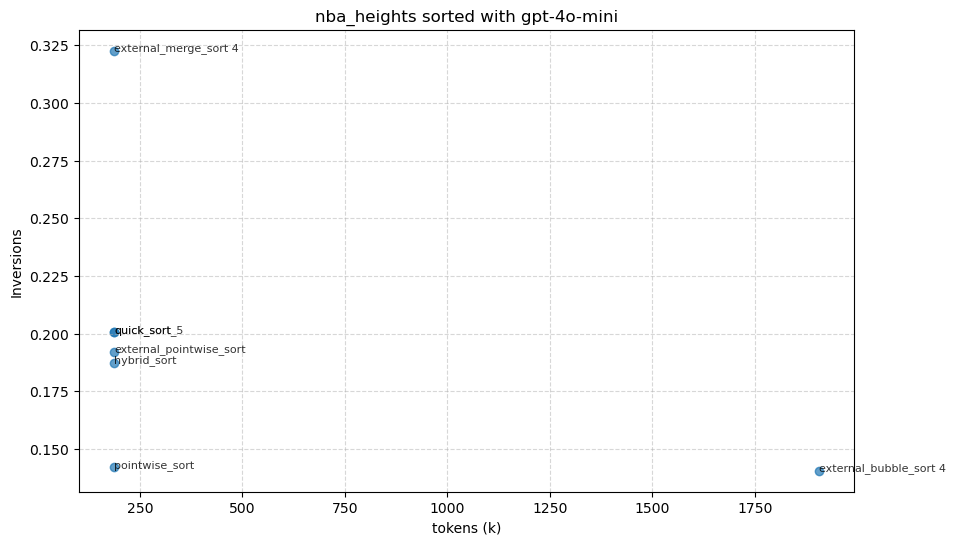

In [19]:
import matplotlib.pyplot as plt


for modelname in loaded_data.keys():
    x_values = []  # Latency
    y_values = []  # Inversions
    labels = []    # To distinguish points
    
    N = len(loaded_data[modelname]['pointwise_sort']['sorted_data'])
    max_inversions = N*(N-1)/2

    # External functions
    for external_function in ['external_bubble_sort', 'external_merge_sort']:
        for m in loaded_data[modelname][external_function].keys():
            k_tokens = loaded_data[modelname][external_function][m]['tokens']/1000
            inversions = loaded_data[modelname][external_function][m]['inversions']
            x_values.append(k_tokens)
            y_values.append(inversions/max_inversions)
            labels.append(f"{external_function} {m}")

    # Internal functions
    for function_name in ['pointwise_sort', 'quick_sort', 'quick_sort_5', 'external_pointwise_sort', 'hybrid_sort']:
        k_tokens = loaded_data[modelname][external_function][m]['tokens']/1000
        inversions = loaded_data[modelname][function_name]['inversions']
        x_values.append(k_tokens)
        y_values.append(inversions/max_inversions)
        labels.append(function_name)

    # Create dot plot
    plt.figure(figsize=(10, 6))
    plt.scatter(x_values, y_values, alpha=0.7)

    # Annotate points with labels
    for i, label in enumerate(labels):
        plt.annotate(label, (x_values[i], y_values[i]), fontsize=8, alpha=0.8)

    plt.title(f"{fname} sorted with {modelname}")
    plt.xlabel("tokens (k)")
    plt.ylabel("Inversions")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()